# Creating Customer Segments

- This project will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import scipy 
import matplotlib.pyplot as pl
import seaborn as sns; sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, FastICA
from sklearn import preprocessing
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load Dataset:

In [16]:
data = pd.read_csv("wholesale-customers.csv")
print "Number of Attributes: %s" % (data.shape[1])
print "Number of Observations: %s" % (data.shape[0])

X=data.ix[:,0:6].values

Number of Attributes: 6
Number of Observations: 440


In [3]:
data.head() #consumption in m.u

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


### Explore the Data:

**1) Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.**

- Principal Component Analysis (PCA) is utilized to identify patterns in dataset based on the correlation between the n-features. PCA attempts to find the directions of maximum variance in a high-dimensional data (d) and then projects it onto a new subspace (k<=d). The two key insights for PCA is found in the below function `data.var()` which illustrates the features that capture the most variance (spread of the data distribution); note that fresh has the highest variance. Also, `data.corr()` since PCA deals with correlation between variables that create the individual eigenvectors. We would expect the first several PCs to be composed of original attributes that are in some way correlated with each other. These principal components could represent the customers that purchases a combination of items from the wholesale grocery distributor. PCA will be discussed in further detail in the following section.


- Additionally, before running any PCA, plotting the histograms (shown below) could suggest a correlation in the number of orders among `Fresh`, `Milk`, and `Grocery`. Intuitively, the histograms show an exponential decline in the number of orders for the respected products, hence this could perhaps be a cluster that consists of the larger size companies with higher purchase quanitites for these particular items. In contrast to the remaining products, the histogram virtually drops off after the first two bins (lower number of orders) and perhaps indicate a smaller company. In addition to `Fresh` and `Grocery` having the highest standard deviations of 12,647 and 9,503 respectively, I would expect these two items to have a high significance (magnitude) in the eigenvector. What we can conclude from the histograms is that the variables have logarithmic distributions, so taking the log of all of the variables would probably give a more normal looking distribution for each variable. A better way of analyzing correlations between two features would be to examine bivariate plots (also shown below histograms) and observe any linear relationships. For instance, there is a positive correlation between milk and grocery items, meaning as the purchase orders of milk increases, so does grocery items. Similarly, as grocery items increase, so does detergents_paper (resembling a grocery store).


- Independent Component Analysis (ICA) is a statistical technique for identifying the underlying hidden factors for a given multidimensional dataset. In short, ICA produces dimensions of variation where the dimensions (features) are statistically independent from one another. The data variables are assumed to be linear mixtures of some unknown "latent" variables and the mixing system is also unknown. The assumption is that the latent variables are both nongaussian and mutually independent; these variables are called the independent components. In the context of this project we are attempting to identify the different buyer types and cluster them together. Being statistically independent, the different types of buyers could mean the size of the purchaser (small/larger) or different consumption patterns. For example, there are buyers who mostly purchased Milk and Grocery, and less Detergents/Paper or Delicatessen. Likely this could represent the type of purchasers for a small market or convenience store.


- Below is some exploratory data analysis which helps us have an understanding of the data we are working with:

In [13]:
# Descriptive Statistics
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115892850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115c363d0>]], dtype=object)

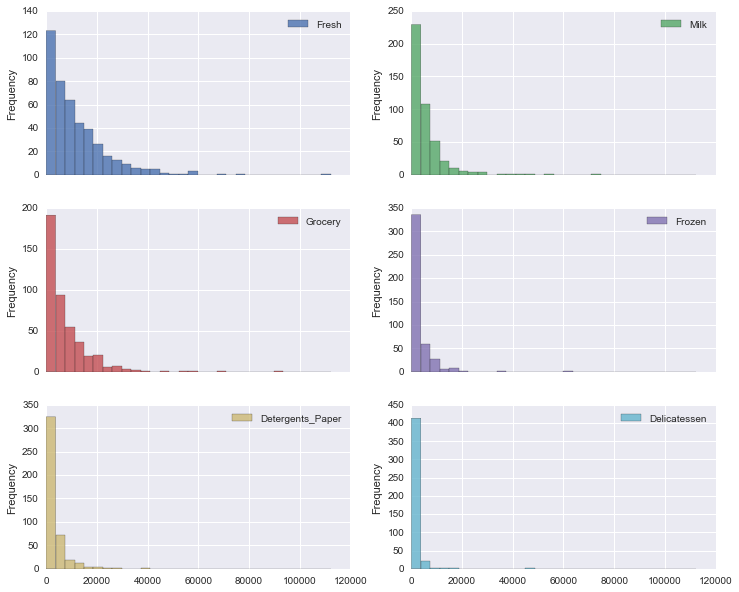

In [11]:
#Histogram
data.plot(kind='hist',alpha=0.8,bins = 30, subplots=True, layout=(3,2), legend=True, figsize=(12,10))

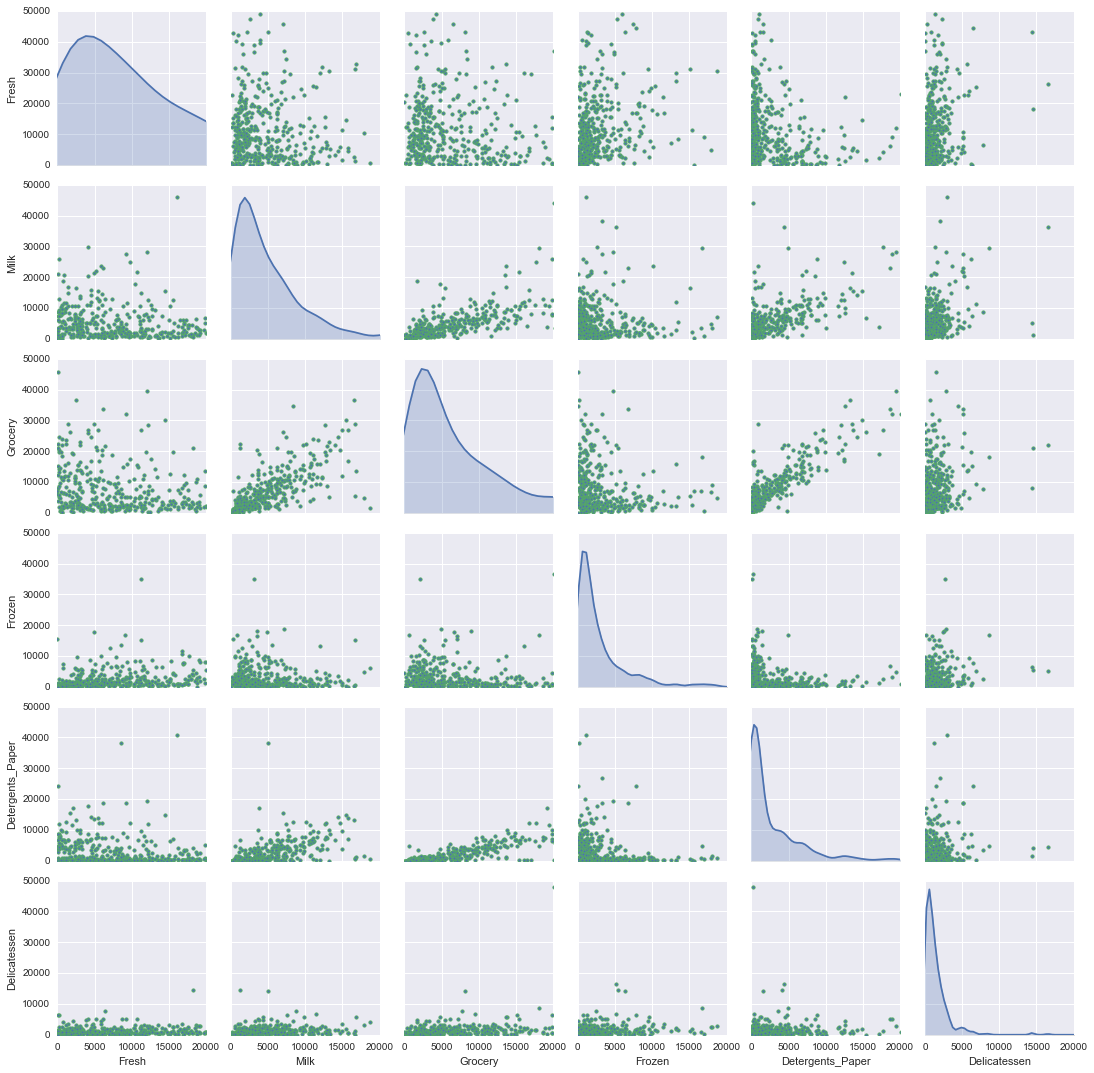

In [18]:
#Bivariate Plot
g = sns.pairplot(data, diag_kind="kde",markers="o", 
                 palette=dict(Fresh="g", Milk="m", Frozen="b", Detergents_Paper="y",Delicatessen="r"),
                 plot_kws=dict(s=10, edgecolor="g", 
                linewidth=1),diag_kws=dict(shade=True))
g.set(ylim=(0,50000))
g.set(xlim=(0,20000))

### Principal Component Analysis:

- Principal component analysis (PCA) is a type of dimension reduction method. Two major features of PCA: through algebraic projection, it represents the original data in a new data space with the same order. The axes (principal components) in the new data space are orthogonal to each other. The newly formed axes are ordered in a sequentially reduced fashion in term of their weight; which simply means that any given principal component captures more variability than the one that immediately follows it. So in summary, principal components are nothing more than the extracted eigenvectors and eigenvalues from a correlation matrix. Using a non-mathematical definition, one can view the eigenvectors as the slope of axes defining a series of ellipses, with the axes always orthogonal to each other (see figure below). 

![alt](https://onlinecourses.science.psu.edu/stat857/sites/onlinecourses.science.psu.edu.stat857/files/lesson05/PCA_plot.gif)


- First, lets begin by constructing the covariance matrix (S). The covariance is the measures how much the features vary from the mean with respect to each other. First, variance and covariance are a measure of the "spread" of a set of points around the mean. Variance measures the deviation from the mean of points in one dimension while covariance measures how much each of the dimensions vary from the mean with respect to each other. The covariance between one dimension and itself is the variance. Covariance is measured between two dimensions to see if there is a relationship between the two dimensions like the number of hours studied and the number of questions the student got wrong. For example, suppose we have a 3x3 matrix (x,y,z) then we can measure the covariance between the x and y dimensions, y and z dimensions, and x and z dimensions. Measuring the covariance between x and x, y and y, z and z result in the variance of x,y, and z respectively. Hence, this would be the main diagonal of the covariance matrix. Also, Cov(x,y) = Cov(y,x), hence the matrix is symmetrical about the main diagonal. Also, the sign of the covarince is very important. A positive value indicates both dimensions increase or decrease together. A negative value indicates one dimension increases while the other decreases. If the covariance is zero, then the two dimensions are independent of each other. This example only consists of three dimensions. However, covariance calculations are very useful when finding relationships between features in higher dimensional spaces (i.e. greater than three) where visualization is difficult.

![alt](http://i.stack.imgur.com/ByTyM.png)
![alt](http://www.codeproject.com/KB/graphics/Face_Recognition/EQ1.jpg)

- The covariance matrix is decomposed into its eigenvectors and eigenvalues; the eigenvectors of S represents the principal components (directions of maximum variance and determined the direction of the new feature space) and the eigenvalues (scalar) correspond to the magnitude of the eigenvectors; in other words, the eignevalues explains the variance along the new featue axes. The eigenvalues are sorted in descending order (largest first) and each eigenvalue is divided by the total variance, yielding the fraction of variance explained.here are as many eigenvectors as there are variables(i.e. attributes). The total variance is then the Trace of the S matrix, which is just the summation of the main diagonal. Eigenvalues are then determined from the axes lengths and there are as many eigenvalues as there are variables; each eigenvalue accounts for a certain percentage of the total variance. We are only interested in the top eigenvectors based on the values of their corresponding eigenvalues. The eigenvector corresponding to the highest eigenvalue will be the first PC and will point in the direction of maximum variance (most information gained) of the dataset. The second eigenvector (v2) will point in direction orthogonal (perpendicular in 2D) to v1. One of the main advantages of using PCA is if you have a dataset with high dimensions you can reduce the number dimensions without losing much of the information. Using the projection matrix (a matrix of our concatenated top eigenvectors), the data is projected onto a new feature space and thus reducing the number dimensions through data compression. Being that the objective is to reduce the dimensionality of the data by compressing it onto a new feature subspace, we chose only the subset of the eigenvectors (principal components) that contains most of the information (variance). 


- For example, if the first principal component (eigenvector 1) has an eigenvalue = 5.45 and there are 10 variables, then this eigenvalue and the first component accounts for 54.5% of the total variance (5.45/10). The eigenvectors are used to create new properties. For instance, if the first three principal components together account for most of the variance, then the number of features in the multidimensional space is reduced from 10 to 3. Principal component 2 (eigenvector 2) is orthogonal (uncorrelated) to the first component and accounts for the second highest variance. In this case principal component 10 accounts for the least amount of the total variance. Eigenvectors can be used to create a linear equation, much like a regression equation, to create new properties and to help classify the original data samples into different groupings. Now in the regards to this work, the original dimensional space the dimensions of the axes are in terms of the amount of monetary units (m.u.) the food distributor sales. The axes are then transposed into the new dimensional space and is now represented by the principal components.  For this dataset, there are 440 elements (n=440) and 6 measurements (m=6), so the covariance matrix would be a 440x6 matrix with 6 real eigenvalues; the remaining 434 eigenvalues are zero. Now, after applying the linear PCA transformation, we have a lower dimensional subspace where the samples are “most spread” along the new feature axes.


In [9]:
# Correlation Matrix:
data.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


In [24]:
# Covariance Matrix:
cov_matrix = data.cov()
cov_matrix

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.599549e+08,9.381789e+06,-1.424713e+06,2.123665e+07,-6.147826e+06,8.727310e+06
Milk,9.381789e+06,5.446997e+07,5.108319e+07,4.442612e+06,2.328834e+07,8.457925e+06
Grocery,-1.424713e+06,5.108319e+07,9.031010e+07,-1.854282e+06,4.189519e+07,5.507291e+06
Frozen,2.123665e+07,4.442612e+06,-1.854282e+06,2.356785e+07,-3.044325e+06,5.352342e+06
Detergents_Paper,-6.147826e+06,2.328834e+07,4.189519e+07,-3.044325e+06,2.273244e+07,9.316807e+05
Delicatessen,8.727310e+06,8.457925e+06,5.507291e+06,5.352342e+06,9.316807e+05,7.952997e+06


In [58]:
# Variance:
print "Variance:"
print data.var()

#Eigenvalue and Eigenvector of covariance matrix
columns=data.columns
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)
sum_ev = sum(eig_vals)

#Explained Variance Ratio
explained_var = eig_vals/sum_ev

x = range(1,7)
data_ = pd.DataFrame(zip(x,explained_var),columns=['PC','Variance'])
print ""
print data_

Variance:
Fresh               1.599549e+08
Milk                5.446997e+07
Grocery             9.031010e+07
Frozen              2.356785e+07
Detergents_Paper    2.273244e+07
Delicatessen        7.952997e+06
dtype: float64

   PC  Variance
0   1  0.459614
1   2  0.405172
2   3  0.070030
3   4  0.044023
4   5  0.006138
5   6  0.015022


**2) How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?**


- The first PC accounts for the highest portion of the total variance or "spread" of the data. The subsequent PC's account for the remaining variability, and usually the first couple of PC's account for roughly 90-95% of the total variance. The below plot shows the variance vs the number of principal components (k=6). Based on this plot, the number of dimensions would be reduced to 2, which explains roughly 86% of the total variance. We could use also use the third PC to explain more of the variance, but for visualizing the data in 2D, only the first two PCs will be considered. In this plot, the ['Explained Variance Ratio`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
is a fraction of the total variance explained by each of the selected components. In regards to how quickly the variance drops off, we can compute the slope of the number of PC components (x) vs the explained variance (y). The slope between PC 1-2 is -0.054 and the slope between 2-3 is -0.335. Furthermore, the slope between PC 3-4 is -0.026 and at this point, the slope begins to level out. Therefore between PC 2-3 you observe the steepest slope as the explained variance ratio begins to quickly decline. The bar plot below is an alternative visualization to observe the change in variance versus the number of principal components. 
 
 
- As a note, for PCA to be implemented correctly, the dataset needs to be standardized (mean equal 0 and standard deviation =1). This needs to be addressed in the event where features are on different scales or different magnitudes of range, and thus causing the results of PCA to be biased in the direction of the features with a larger range. One approach to scaling the data is using [`Scale`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html); this function centers the mean and component wise scale to unit variance. However, it may not always be the case in which the data should be standardized. In some instances you may want to preserve the variance of each dimension as opposed to scaling to unit length, which could remove the potential dependence between features since each feature is scaled independently. The features were not scaled to stdev = 1 for this dataset as the attributes have the same units monetary units (m.u.) and in essence, we are trying to capture the variance in spending among the different types of customers.

#### **3)** What do the dimensions seem to represent? How can you use this information? 

- The dimensions of the first PC (explains the most variability in the data) and has coefficients of `Fresh = -0.976`, `Frozen = -0.152`,`Milk = -0.121`, etc. We can clearly see that fresh items have the largest magnitude, followed by frozen products, and then milk. The descriptive statistics shows that on average, fresh items are purchased 55% more than the other 5 products. The annual spending on fresh items has the largest standard deviation (12,647) which suggest there is a lot of variance between the customers on how much they spend on fresh items. As the first PC identifies the item as the most important factor among the features, it would be a good idea to increase marketing towards the customer base for fresh products as it seems to be a cluster of those who buys fresh produce in bulk quanitites.


- Second Principal Component gives the following magnitudes for the eigenvector v2: `Fresh = -0.110614` `Milk =0.515802`, `Grocery =0.764606`, `Frozen = -0.018723` etc. Looking at the magnitude of the eigenvector, a correlation exist among `Grocery` and `Milk`; customers who buy more 'grocery' items also tend to buy more 'milk' items as well. Therefore, it would be advised to market grocery and milk products together given their correlation in order to increase sales. Bundling these two items when shipping to the customer will also reduce cost.


- In summary, the 1st principal component is strongly correlated with the "Fresh" variable. The 1st principal component increases as the "Fresh" variable decreases. This component can be viewed as a measure of how "Fresh" orders decline with high-volume customers. Because of the high correlation for "Fresh" (-0.97), this principal component is primarily a measure of the "Fresh" variable. Therefore, high-volume customers order much less "Fresh" items (in comparison to other items) than low-volume customers.

In [60]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset

#Subtracting out the mean to center the data:
columns = data.columns
mean = data.mean()
df_m = pd.DataFrame(mean)
df_mean = df_m.transpose()
data_center = pd.DataFrame(data[columns].values - df_mean[columns].values, columns=columns)
#print data_center

def doPCA():
    pca = PCA(n_components=5)
    pca.fit(data_center)
    return pca

# Print the components and the amount of variance in the data contained in each dimension
pca = doPCA()
columns = data.columns
df_ica = pd.DataFrame(pca.components_, columns = columns, index=['1', '2', '3', '4','5'])
df_ica.index.names = ['PC']
print "Principal Component Analysis:"
print df_ica

ex_var = pca.explained_variance_ratio_
df_var = pd.Series(ex_var,index=['1','2','3','4','5'])
df_var.sort(ascending=False)


df_var.index.names = ['PC']
print "\nExplained Variance of Each Component:"
print df_var

Principal Component Analysis:
       Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
PC                                                                        
1  -0.976537 -0.121184 -0.061540 -0.152365          0.007054     -0.068105
2  -0.110614  0.515802  0.764606 -0.018723          0.365351      0.057079
3  -0.178557  0.509887 -0.275781  0.714200         -0.204410      0.283217
4  -0.041876 -0.645640  0.375460  0.646292          0.149380     -0.020396
5   0.015986  0.203236 -0.160292  0.220186          0.207930     -0.917077

Explained Variance of Each Component:
PC
1    0.459614
2    0.405172
3    0.070030
4    0.044023
5    0.015022
dtype: float64


[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212]


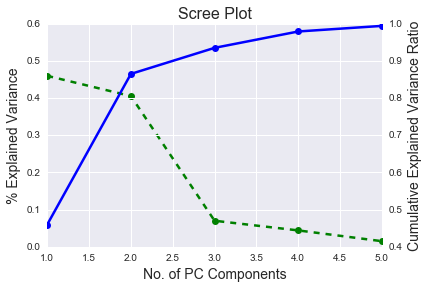

In [70]:
#Scree Plot:
x = np.arange(1,6)
y1 = ex_var
print y1
y2 = np.cumsum(ex_var)

pl.figure(figsize=(16,18))
fig, ax1 = pl.subplots(1,1)
ax2 = ax1.twinx()

#Generate Curves
ax1.plot(x,y1,color = 'green',linewidth=2.5, linestyle='--',marker='o')
ax2.plot(x,y2,color = 'blue',linewidth=2.5,marker='o')

#Set Axes Labels:
ax1.set_xlabel("No. of PC Components", fontsize = 14)
ax2.set_ylabel("Cumulative Explained Variance Ratio",fontsize =14)
ax1.set_ylabel("% Explained Variance", fontsize =14)

#Set Limits:
ax2.set_ylim(0.4,1,.2)
ax1.set_ylim(0,.6,.2)
ax1.set_xlim(1,5)

pl.title("Scree Plot", fontsize = 16)
pl.legend()
pl.show()

Slope1: -0.054442
Slope2: -0.335142
Slope3: -0.026007


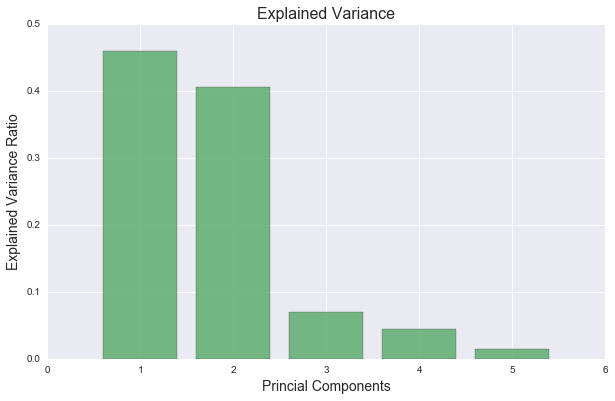

In [61]:
pl.figure(figsize=(10,6))
pl.bar(range(1,6), ex_var, alpha = .8, align='center',
       label = 'Individual Explained Variance', color = 'g')
pl.ylabel('Explained Variance Ratio', fontsize = 14)
pl.xlabel('Princial Components', fontsize = 14)
pl.title('Explained Variance', fontsize = 16)
pl.show

#Slope:
X1, Y1 = 1, 0.459614
X2, Y2 = 2, 0.405172
X3, Y3 = 3, 0.070030
X4, Y4 = 4, 0.044023
slope1 = (Y2-Y1)/(X2-X1)
slope2 = (Y3-Y2)/(X3-X2)
slope3= (Y4-Y3)/(X4-X3)
print "Slope1:", slope1
print "Slope2:", slope2
print "Slope3:", slope3

(-1.0, 1.5)

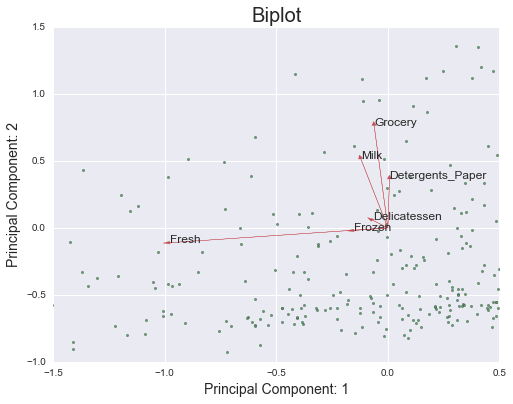

In [13]:
def biplot(df):
    # Fit on 2 components
    #Scaling 
    pca = PCA(n_components=2, whiten=True).fit(df)
    
    # Plot transformed/projected data
    ax = pd.DataFrame(
        pca.transform(df),
        columns=['PC1', 'PC2']
    ).plot(kind='scatter', x='PC1', y='PC2', figsize=(8, 6), color = 'g', s=5)
    # Plot arrows and labels
    for i, (pc1, pc2) in enumerate(zip(pca.components_[0], pca.components_[1])):
        ax.arrow(0, 0, pc1, pc2, width=0.001, fc='r', ec='r')
        ax.annotate(df.columns[i], (pc1, pc2), size=12)
    return ax

ax = biplot(data)
pl.title("Biplot", fontsize = 20)
pl.xlabel("Principal Component: 1", fontsize = 14)
pl.ylabel("Principal Component: 2", fontsize = 14)
ax.set_xlim([-1.5, .5])
ax.set_ylim([-1.0, 1.5])

### Independent Component Analysis:

**4) For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?**

- [`Independent Component Analysis`](http://scikit-learn.org/stable/modules/decomposition.html#ica) is an algorithm that finds directions in the feature space corresponding to projections with high non-Gaussianity. ICA will provide six new vectors with each vector being an independent component. Furthermore with ICA, we can attempt to identify the different types of customers so that we can understand more of their consumption patterns. In ICA, we are taking into account the positive and negative signs of the coefficient as they are considered anti-correlated to each other. This simply means that if we have a high positive coefficient and a very negative coefficient, it would be interpreted as one or another but not both, hence anti-associated to each other.


- Before running ICA, we can use a preprocessing technique such as [`Scale`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html) to center the data to zero and gives each column a variance of 1; removing the mean can help measure the variance of the data now from the origin (origin). This could still be done by keeping the mean, the only difference now is that the center is the mean itself, and not 0. The calculations are more simpler when you remove the mean as oppose to keeping it. Also, having the values centered at zero can capture the distributions when transforming the data.


- **ICA1:** Mostly includes frozen items (highest relative magnitude); the customers tend to buy more grocery/frozen items and less detergents_paper/delicatessen/fresh/milk products. Possibly could resemble smaller sized grocery store where larger quanities of grocery/frozen foods are majority of the purchase orders for this particular cluster of clients. 

- **ICA2:** As shown the the below heatmap, we see that grocery items has the strongest component. We see that customers who buy more fresh produce also buys less milk/detergents_paper/delicatessen. This could suggest a smaller restaurants, where majority of the demand is for fresh/grocery/frozen


- **ICA3:** The most significant purchase orders from the distributor is for delicatessens while decrease in the remaining products. This suggests a group of customers that own a deli/sandwich shop.


- **ICA4:** In this IC, grocery has the highest postive relative magnitude (0.11) while in contrast, detergents_papers has the lowest negative magnitude (-0.13). This is an example where a component has a large positive coefficient and a relatively large negative coefficient (compared to the remaining features). There is an anti-correlation between grocery and detergent purchases. Possibly this could come from a distinction between something like grocery stores and pharmacies which carry some food but far more paper products. It would be interesting to see what time of year where you see large increases in grocery items and less in detergents_paper and vice versa. Could this possibily correspond to the holiday seasons where demand for grocery items tends to increase.


- **ICA5:** Customer purchases mostly milk/grocery/ will buy less slightly less fresh items and detergents (possibly a convenience store)


- **ICA6:** Primarly as purchase orders for grocery increases, milk/fresh decrease. This group of looks very similar to ICA5 and follows trends that more closely look like a convenience or small market store. 

In [14]:
#Adjust the data to have center at the origin:
columns = data.columns
scale = preprocessing.scale(data)
df_scale = pd.DataFrame(scale, columns=columns)
#print data_scaled.mean()
#print data_scaled.std()

def doICA():
    ica = FastICA(n_components = 6, random_state=42)
    ica.fit(df_scale)
    return ica

# Print the independent components
ica = doICA()

In [15]:
df_ica = pd.DataFrame(ica.components_,columns=columns, index=['1','2','3','4','5','6'])
df_ica.index.names = ['IC']
print "\nUnmixing Matrix:"
df_ica


Unmixing Matrix:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
IC,,,,,,
1,-0.010908,-0.001086,0.007308,0.054056,-0.002541,-0.016757
2,0.002538,-0.012328,0.069129,0.001424,-0.013749,-0.005441
3,-0.004906,-0.001539,-0.005621,-0.002525,0.002384,0.050929
4,-0.003363,0.018630,0.108990,-0.007232,-0.133386,-0.016023
5,-0.050266,0.006472,0.007482,0.003224,-0.011471,0.002708
6,-0.001939,-0.072455,0.056476,0.001674,-0.017140,0.016956


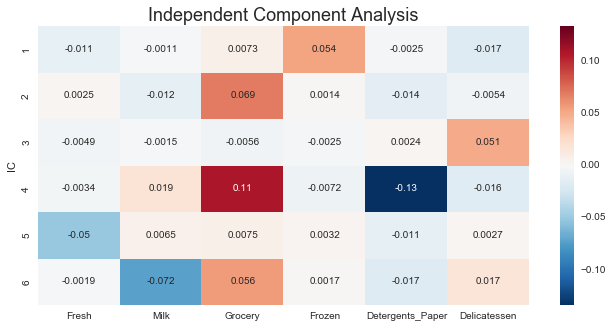

In [16]:
pl.figure(figsize=(20,20))
pl.figure(figsize = (11,5))
pl.title('Independent Component Analysis', fontsize=18)
sns.heatmap(df_ica, annot = True)

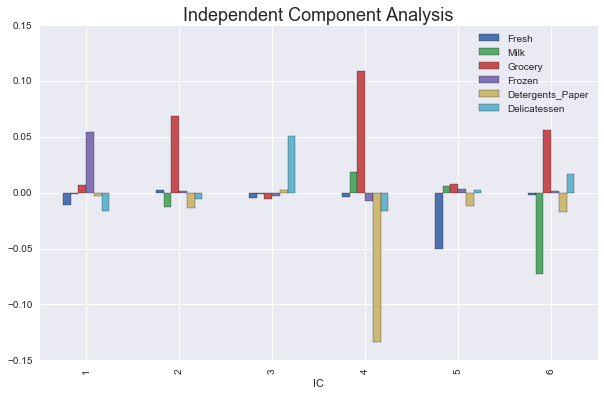

In [20]:
# Another way we can veiw ICA
df_ica.plot(kind = 'bar', figsize = (10, 6))
pl.title('Independent Component Analysis', fontsize=18)

### Clustering:

- Using K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then sample elements from the clusters to understand their significance.

**5) What are the advantages of using K Means clustering or Gaussian Mixture Models?**

- In unsupervised learning, we are not predicting an outcome (no target label is given "y"); we are interested in how the features are related. We can group the data into "clusters" and two common techniques are K-means and Gaussian Mixture Models.


- K-mean is an iterative algorithm that is based on the idea that there exist a specific number of clusters or groups in the dataset and finds clusters that consists of similar characteristics that are more related to each other than in other groups. Each group in the data is distributed around a central point called the "centroid" which is the average of the cluster. K-means begins by initially guessing the K-number of clusters and then the algorithm randomly picks the centroid as the initial clusters of the data (not the correct centers for the first iteration). All of the points are assigned to the nearest centroid based on the Euclidian distance and is grouped into a cluster. The new centroid will be the mean of data points assigned to the corresponding cluster. This process is repeated until either the number of specified iterations is reached or until the clustering assignments do not change. Using K-Means in scikit-learn, the iteration will stop early if it converges before the maximum number of iterations is reached. As a note, incorrectly assigning the number of clusters for k can result in poor clustering performance. Next, each sample is assigned to the nearest centroid and then move the centroid to the center of the corresponding samples. 


- K- mean is a hard clustering algorithm, where the clusters to not overlap (i.e. the data point is either "blue" or "green". The advantages of using K-means is due to it's simplicity, speed, and scalability of larger numbers of data points. However, one weakness when using this method is that the initial centroids are placed randomly, which could result in a bad starting spot and the iteration could stop at an unlikely solution. Thus numerous iterations need to be run which can come at a cost of more time required to run K-means, however the trade-off is that more iteration that are conducted, the better the results will be.  


- A generalization of K Means algorithm is Gaussian Mixture Models (GMM). GMM assumes that all of the data points in each cluster are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. GMM use a Gaussian distributions to find the most probable cluster that a point would belong to. The mixture model attempts to find unknown parameters such as the mean/covariance of the Gaussian distribution. The parameters of the GMM are estimated by the maximum likelihood criterion using the Expectation-Maximization (EM) algorithm. EM algorithm is very sensitive to the initialization of the model, thus it can require a longer time to converge if there is a poor initial guess. Another disadvantage of the GMM algorithm is that can fail if the dimensionality of the dataset is too high (i.e. greater d=6). In many cases, how many mixture models should be used is unknown and a different number of mixture models (n_components) will to have to be experimented with. Alternatively, one advantage of using mixture models (Gaussian distribution) it is a probabilistically way of doing soft clustering. Soft clustering is often desired as it provides uncertainties on the assignment of data points to a given cluster rather than K-means, which classifies the point of interest to belong to only a single cluster. Another strength of using mixture models are that the model covers the data well and that a density estimation for each cluster can be obtained. Therefore, GMM will be considered in the analysis, however in the code below, results for both K-Means and GMM are shown.


The two main differences between the two models are speed and structure:

- **Speed:**
    - K-Mean much faster and much more scalable
    - GMM slower since it has to incorporate information about the distributions of the data, thus it has to deal with the co-variance, mean, variance, and prior probabilities of the data, and also has to assign probabilities to belonging to each clusters.


- **Structure:**

    - K-Means straight boundaries (hard clustering)
    - GMM you get much more structural information, thus you can measure how wide each cluster is, since it works on probabilities (soft clustering)


**6)** Below is the code to visualize the clusters (Gaussian Mixture Model & K-Means)

In [27]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [34]:
# TODO: Reduce to Two dimensions using PCA to capture variation
reduced_data = PCA(n_components = 2).fit_transform(data)
df_rd = pd.DataFrame(reduced_data)
df_rd[:11]

,0,1
0,-650.022122,1585.519090
1,4426.804979,4042.451509
2,4841.998707,2578.762176
3,-990.346437,-6279.805997
4,-10657.998731,-2159.725815
5,2765.961593,-959.870727
6,715.550892,-2013.002266
7,4474.583667,1429.496972
8,6712.095397,-2205.909156
9,4823.634354,13480.559205


- In order to evaluate the quality of the clustering, we need to find the optimal number of clusters. This can be done by computing the inertia, a method for comparing the performance of different k-means clusters (n_clusters). Inertia is calculated by taking the summation of the difference between every data point in each cluster and it's respected centroid. Inertia is accessible is calling the `inertia__` function, which computes the within cluster SSE. If the data points in the cluster are similar to it's centroid, the difference is small, resulting in a small inertia. Plotting the number of clusters vs the inertia yields the plot below. What is important from this plot is to observe the rate of change. We see that as the number of clusters increase, the lower the inertia will be. This is due to the samples being closer to their corresponding centroids. Basically, the idea behind this plot is to identify the value of k where the inertia begins to increase most rapidly, thus the optimal number of clusters to consider in this model is between 4-5. 


- As GMM was ultimately chosen, [`BIC score`](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html) is more appropriate to determine the number of clusters. Bayesian information criterion or (BIC). Most often the case, the number of components for the mixture model and covariance are unknown. One way to tune a GMM is by comparing information criteria and the two most popular information criteria are Akaike's Information Criterion (AIC) and (BIC). In this analysis, we will consider only the BIC score. The model giving smallest BIC score is selected as the best model, however BIC tends to choose simpler models that may underfit the data. We can conclude from the BIC histogram, the models perform the best when for n_components = 5. More on Clustering Using Gaussian Mixture Models can be found [`here`] (http://www.mathworks.com/help/stats/clustering-using-gaussian-mixture-models.html).


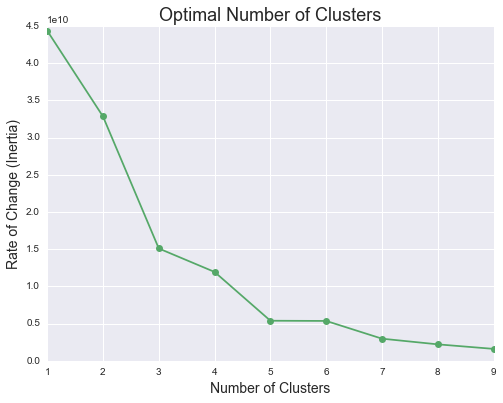

In [35]:
def number_clusters():
    inertia = []
    delta_inertia = []
    for i in range(1,11):
        clustering = KMeans(n_clusters = i,
                    n_init=10,
                    max_iter=300,
                    random_state=1)
        clustering.fit(reduced_data)
        if inertia: 
            delta_inertia.append(inertia[-1] - clustering.inertia_)
        inertia.append(clustering.inertia_)
    
    pl.figure(figsize=(8,6))
    pl.plot([k for k in range(1,10)], delta_inertia, marker='o', color='g')
    pl.title('Optimal Number of Clusters', fontsize=18)
    pl.xlabel('Number of Clusters', fontsize=14)
    pl.ylabel('Rate of Change (Inertia)', fontsize=14)
    pl.show
    
number_clusters()

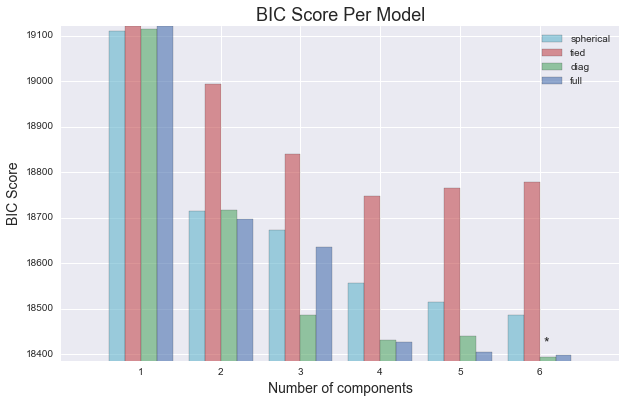

In [36]:
#This plot was generated using the sample code from: 
#http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#example-mixture-plot-gmm-selection-py

import itertools

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = GMM(n_components=n_components, covariance_type=cv_type)
        gmm.fit(reduced_data)
        bic.append(gmm.bic(reduced_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['c', 'r', 'g', 'b'])
bars = []            

ax = pl.figure(figsize=(10,6))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(pl.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color, alpha=0.6))
pl.xticks(n_components_range)
pl.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
pl.title('BIC Score Per Model', fontsize=18)

xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
pl.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
pl.xlabel('Number of components', fontsize=14)
pl.ylabel('BIC Score', fontsize=14)
pl.legend([b[0] for b in bars], cv_types)

### Gaussian Mixture Model

Gaussian Mixture Model:
Cluster Number: 1
Number of samples in cluster: 134
Fresh               5647.574627
Milk                1921.097015
Grocery             2348.149254
Frozen              2641.500000
Detergents_Paper     473.194030
dtype: float64
Gaussian Mixture Model:
Cluster Number: 2
Number of samples in cluster: 112
Fresh               18331.660714
Milk                 2986.392857
Grocery              4011.607143
Frozen               3852.053571
Detergents_Paper      835.321429
dtype: float64
Gaussian Mixture Model:
Cluster Number: 3
Number of samples in cluster: 17
Fresh               17046.529412
Milk                29016.411765
Grocery             39851.588235
Frozen               4599.176471
Detergents_Paper    18424.117647
dtype: float64
Gaussian Mixture Model:
Cluster Number: 4
Number of samples in cluster: 40
Fresh               39767.175
Milk                 6455.875
Grocery              7936.275
Frozen               6684.375
Detergents_Paper     1664.900
dtype: float6

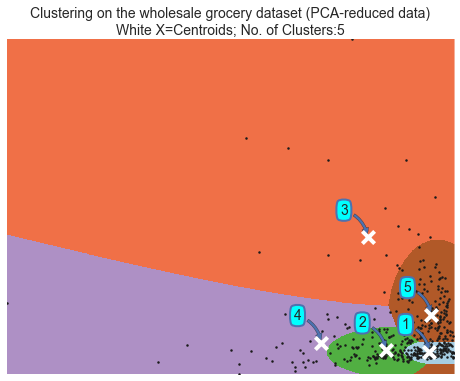

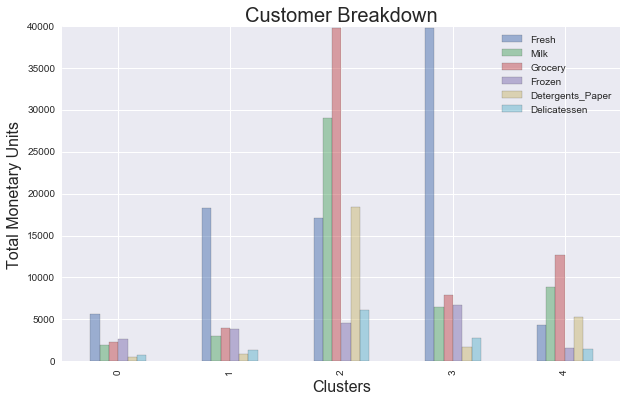

In [37]:
def cluster_plot_gmm():   
    n = 5
    # TODO: Implement clustering algorithm and fitting to the reduced data for visualization
    gmm = GMM(n_components=n, n_iter=300)
    clusters = gmm.fit(reduced_data)
    centroids = clusters.means_
    
    x_gmm = clusters.predict(reduced_data)

    # Which customers are in which cluster: K-Means
    for i in range(0,5):
        count = data[x_gmm==i].shape[0]
        print 'Gaussian Mixture Model:'
        print 'Cluster Number: %s' % (i+1)
        print 'Number of samples in cluster: %s' % count
        print data[x_gmm==i][list(data.columns[:-1])].mean()

    # Plot the decision boundary by building a mesh grid to populate a graph.
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    pl.figure(figsize=(8,6))
    Z = Z.reshape(xx.shape)
    pl.figure(1)
    pl.clf()
    pl.imshow(Z, interpolation='nearest',
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                cmap=pl.cm.Paired,
                aspect='auto', origin='lower')

    pl.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=5)
    pl.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=150, linewidths=4,
                color='w', zorder=10)
    pl.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
            'White X=Centroids; No. of Clusters:%s'%(5), fontsize = 14)
    pl.xlim(x_min, x_max)
    pl.ylim(y_min, y_max)
    pl.xticks(())
    pl.yticks(())

    # Annotate Plot:
    labels = ['{0}'.format(i) for i in range(1,6)]
    for label, x, y in zip(labels, centroids[:,0], centroids[:,1]):
         pl.annotate(label, xy = (x, y), xytext = (-20, 20),
         textcoords = 'offset points', size=14, ha = 'right', va = 'bottom',
         bbox = dict(boxstyle="round4,pad=0.3", fc="cyan", ec="b", lw=2),
         arrowprops = dict(arrowstyle = 'simple', connectionstyle = 'arc3,rad=-0.3'))
    pl.show()
    
    data['cluster'] = clusters.predict(reduced_data)
    results = pd.DataFrame(data=labels, columns=['cluster']) 
    data_grouped = data.groupby('cluster').mean()
    
    # Histogram
    ax = data_grouped.plot(kind='bar',legend=True, 
                    figsize=(10,6), alpha=.5, title="Customer Breakdown")
    ax.set_xlabel("Clusters",fontsize=16)
    ax.set_ylabel("Total Monetary Units",fontsize=16)
    ax.set_title(ax.get_title(), fontsize=20)
    pl.show()

cluster_plot_gmm()

### K-Means

Kmeans:
Cluster Number: 1
Number of samples in cluster: 103
Fresh               21480.388350
Milk                 3911.601942
Grocery              5154.563107
Frozen               4188.650485
Detergents_Paper     1131.912621
Delicatessen         1712.135922
dtype: float64
Kmeans:
Cluster Number: 2
Number of samples in cluster: 228
Fresh               6106.714912
Milk                3304.574561
Grocery             4175.855263
Frozen              2421.548246
Detergents_Paper    1266.078947
Delicatessen         995.333333
dtype: float64
Kmeans:
Cluster Number: 3
Number of samples in cluster: 7
Fresh               20031.285714
Milk                38084.000000
Grocery             56126.142857
Frozen               2564.571429
Detergents_Paper    27644.571429
Delicatessen         2548.142857
dtype: float64
Kmeans:
Cluster Number: 4
Number of samples in cluster: 23
Fresh               49330.739130
Milk                 6823.260870
Grocery              6338.521739
Frozen               9666.08695

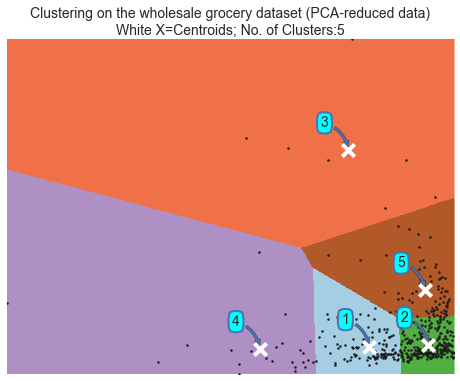

K-Means:
Number of Customers per Cluster:
4    137
0    134
1    112
3     40
2     17
Name: cluster, dtype: int64


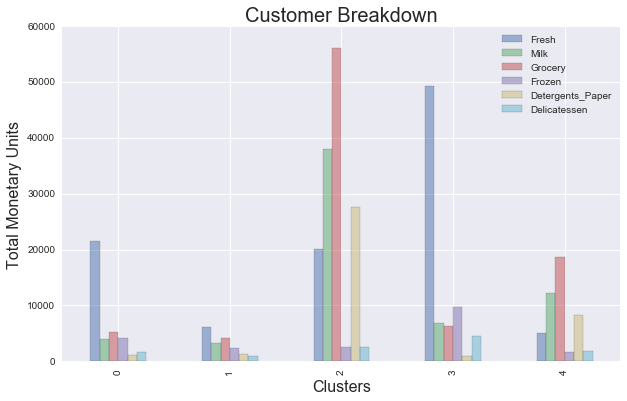

In [38]:
def cluster_plot_kmeans():  
    num_clusters = 5
    clusters = KMeans(n_clusters=num_clusters, n_init=100)
    clusters.fit(reduced_data)
    centroids = clusters.cluster_centers_
    
    x_km = clusters.predict(reduced_data)

    # Which customers are in which cluster: K-Means
    for i in range(0,5):
        count = data[x_km==i].shape[0]
        print 'Kmeans:'
        print 'Cluster Number: %s' % (i+1)
        print 'Number of samples in cluster: %s' % count
        print data[x_km==i][list(data.columns[:-1])].mean()

    # Plot the decision boundary by building a mesh grid to populate a graph.
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    pl.figure(figsize=(8,6))
    Z = Z.reshape(xx.shape)
    pl.figure(1)
    pl.clf()
    pl.imshow(Z, interpolation='nearest',
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                cmap=pl.cm.Paired,
                aspect='auto', origin='lower')

    pl.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=5)
    pl.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=150, linewidths=4,
                color='w', zorder=10)
    pl.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
            'White X=Centroids; No. of Clusters:%s'%(5), fontsize = 14)
    pl.xlim(x_min, x_max)
    pl.ylim(y_min, y_max)
    pl.xticks(())
    pl.yticks(())

    # Annotate Plot:
    labels = ['{0}'.format(i) for i in range(1,6)]
    for label, x, y in zip(labels, centroids[:,0], centroids[:,1]):
         pl.annotate(label, xy = (x, y), xytext = (-20, 20),
         textcoords = 'offset points', size=14, ha = 'right', va = 'bottom',
         bbox = dict(boxstyle="round4,pad=0.3", fc="cyan", ec="b", lw=2),
         arrowprops = dict(arrowstyle = 'simple', connectionstyle = 'arc3,rad=-0.3'))
    pl.show()
    
    print "K-Means:"
    print "Number of Customers per Cluster:"
    print data['cluster'].value_counts()

    data['cluster'] = clusters.labels_
    results = pd.DataFrame(data=labels, columns=['cluster']) 
    data_grouped = data.groupby('cluster').mean()
    
    # Histogram
    ax = data_grouped.plot(kind='bar',legend=True, 
                    figsize=(10,6), alpha=.5, title="Customer Breakdown")
    ax.set_xlabel("Clusters",fontsize=16)
    ax.set_ylabel("Total Monetary Units",fontsize=16)
    ax.set_title(ax.get_title(), fontsize=20)
    pl.show()

cluster_plot_kmeans()

**7) What are the central objects in each cluster? Describe them as customers.**

- The central object of each cluster is in reference to the above Gaussian Mixture Model (GMM) and K-Means cluster plot and histogram. For the sake of this discussion, we will explore the results from the GMM. As a note on the histogram, the cluster labeling begins at 0; this refers to cluster 1 and so on. What we find in the first cluster is a higher precentage of fresh, milk, grocery, and frozen products but with lowest consumption among the remaining clusters. To the left of cluster 1 is the second cluster (green) which contains 133 samples. The fresh items are the most significant, which reflects the results discussed earlier with `fresh` having the highest magnitude in the first PC, thus more influential. The first two clusters indiciate this customer base to be a smaller-sized familiy run corner store or convience store with lower consumption patterns. The third cluster shows larger consumption patterns which would classify this group as the larger grocery stores such as Whole Foods or Trader Joes. Only 17 stores fall into this cluster, which is just a small fraciton of the total customers. The fourth cluster has a total of 38 customers and the most significant item in this cluster is a high consumption of fresh products. Consumption for Milk, grocery, and frozen items drops off by nearly 75% in this cluster, perhaps representing the trends associated with a restaurant/fast-food that has a high density of fresh products. The fifth cluster consists of a customer base that would most likely resemble a smaller neighborhood grocery store with the bulk of the products purchased being fresh/milk/grocery items. 


### Conclusion:

**8) Which of these techniques did you feel gave you the most insight into the data? **

- Applying Principal Component Analysis was one of the most useful techniques as it provides insight into the data. We were able to reduce the high dimensional dataset to a lower dimensional space which allowed the data to be visualized on a two dimensional scatter plot. The data was projected onto the new principal component axes and each datapoint in the plot represents a single class (customer). Additionally, PCA is a feature extractor, thus we are able to identify which attributes are most significant in each principal component. After applying PCA, the second most useful method is then implementing GMM to the reduced dataset in order to group the customers into respective market segments, which can enhance better decision making.

**9) How would you use that technique to help the company design new experiments?**

- As we have classified the wholesale customers into different markets, applying the A/B test would help the company with making any changes to the business model. A/B testing, often called split testing, is widely used when creating web pages by comparing two versions of a web page and see which one performs better. Likewise, applying A/B testing to this dataset will allow the company to make optimal decisions by trying out possible changes and seeing what performs better. For an example, we may want to test various pricing options for products to monitor how the change in price affects purchase rate for a particular market. We can split the cluster into two groups with the goal of determining if the rate of success is higher in one group (A) than the other (B). As a note, each cluster could have its own A/B test to eliminate any effects of different customer types or customer sizes. One way to do this is determine the p-value to get an idea of how confident we are that the two groups have different chances of success. Using the common baseline of "statistically significant" at 0.05, a p-value lower than 0.05 means the two groups are different. But the estimated improvement in success rate would give a better idea of how much better/worse any changes might be compared to initial prices. There are numerous instances on what could be analyzed, but this example would just give an idea on how we can make optimal business decisions by applying any new changes to how the company operates. 

**10) How would you use that data to help you predict future customer needs?**

- Once we have defined the customer base, we can then target particular customers by performing different tests in order to enhance profit and growth of the company. After applying PCA and GMM, we have grouped the data into clusters and now the company can utilize a supervised machine learning model, either regression or classification, to predict which cluster the new customer is likely to fall in. For instance, we could extract the customers and their corresponding consumption elements (Fresh, frozen, etc.) from the Gaussian Mixture Model and use then use their respected cluster as the label to use a classification learning algorithm. This would then allow the company to make prediction on future customers and their purchase orders and also how they could make any changes to the distribution operations. Another suggestion would be to use regression on the clusters that were identified in order to predict purchase orders from current stores and future wholesale customers.